## Aggregate traffic data to grid and compare gridded traffic with gridded NOx data

In [180]:
!pip install geopandas==0.9.0

In [181]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import shutil

#### Load NOx data

In [182]:
nox = xr.open_dataset('./data/nox/coco_hourly_europe.nc')['EMISSIONS_2019']
nox

<xarray.DataArray 'EMISSIONS_2019' (time: 720, latitude: 15, longitude: 16)>
[172800 values with dtype=float32]
Coordinates:
  * longitude  (longitude) float32 8.5 8.6 8.7 8.8 8.9 ... 9.6 9.7 9.8 9.9 10.0
  * latitude   (latitude) float32 44.65 44.75 44.85 44.95 ... 45.85 45.95 46.05
  * time       (time) datetime64[ns] 2019-05-01 ... 2019-05-30T23:00:00
Attributes:
    standard_name:  NOx_EMISSIONS_2019
    long_name:      NOX_EMISSIONS_2019
    units:          kg m-2 s-1

#### Create grid based on NOx data coordinates

In [183]:
grid = nox.mean('time').to_dataframe().reset_index()
grid['latitude'] = np.round(grid.latitude, decimals=2)
grid = gpd.GeoDataFrame(grid, geometry=gpd.points_from_xy(grid.longitude, grid.latitude))
grid.geometry = grid.buffer(0.05).envelope
grid.crs = 'epsg:4326'
grid.head()

,latitude,longitude,EMISSIONS_2019,geometry
0,44.65,8.5,3.157931e-11,"POLYGON ((8.45000 44.60000, 8.55000 44.60000, ..."
1,44.65,8.6,5.662939e-11,"POLYGON ((8.55000 44.60000, 8.65000 44.60000, ..."
2,44.65,8.7,1.638106e-11,"POLYGON ((8.65000 44.60000, 8.75000 44.60000, ..."
3,44.65,8.8,5.188910e-11,"POLYGON ((8.75000 44.60000, 8.85000 44.60000, ..."
4,44.65,8.9,5.446679e-11,"POLYGON ((8.85000 44.60000, 8.95000 44.60000, ..."


#### Load traffic data

In [184]:
traffic = gpd.read_file('zip://data/traffic/20210704_1903.zip')
traffic.head()

,DE,PC,QD,LE,SU,SP,JF,FF,CN,geometry
0,Verzweigung Lugano-Nord,10153,+,1.33538,90.40,88.60,0.00000,75.3,0.92,"MULTILINESTRING ((8.92864 46.04003, 8.92870 46..."
1,Lugano-Nord,10819,+,0.18747,45.18,45.18,0.34456,47.0,0.94,"MULTILINESTRING ((8.93057 46.02776, 8.93052 46..."
2,Massagno,10820,+,1.71292,74.39,74.39,0.22201,76.3,0.96,"MULTILINESTRING ((8.93086 46.02729, 8.93101 46..."
3,Massagno,10820,-,0.05107,43.38,43.38,0.00000,39.0,0.84,"LINESTRING (8.93589 46.01725, 8.93617 46.01735..."
4,Lugano-Nord,10819,-,1.67036,64.29,64.29,0.48485,68.0,0.82,"MULTILINESTRING ((8.93548 46.01695, 8.93528 46..."


#### Aggregate traffic data to this grid

In [185]:
%%time 

sindex = traffic.sindex
# traffic = traffic.set_crs('epsg:4326')

CPU times: user 870 ms, sys: 41.4 ms, total: 911 ms
Wall time: 911 ms


In [186]:
%%time 

for index, row in grid.iterrows():
    if index%40==0:
        print(index)
    geom = grid.iloc[index:index+1]
    possible = list(sindex.intersection(geom.total_bounds))
    pdf = traffic.iloc[possible]
    clipped = gpd.clip(pdf, geom)
    grid.loc[index, 'traffic'] = (clipped.length).sum()

0


<timed exec>:7: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:4326



40
80
120
160
200
CPU times: user 21.6 s, sys: 228 ms, total: 21.8 s
Wall time: 21.8 s


#### Correlation between traffic and emissions

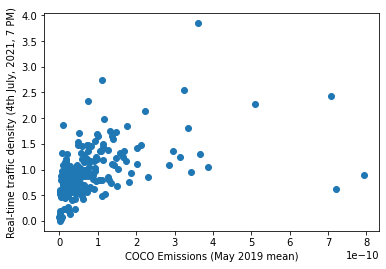

In [193]:
plt.scatter(grid.EMISSIONS_2019, grid.traffic)
plt.xlabel('COCO Emissions (May 2019 mean)')
plt.ylabel('Real-time traffic density (4th July, 2021, 7 PM)')
plt.savefig('Traffic_emissions_correlation.png', dpi=240)

In [191]:
import scipy.stats as ss

In [192]:
r = ss.pearsonr(grid.EMISSIONS_2019, grid.traffic)[0]
print("Correlation coefficient R = %.3f"%(r))

Correlation coefficient R = 0.455


#### Spatio-temporal

In [49]:
import os
from datetime import datetime as dt

In [149]:
grid = nox.mean('time').to_dataframe().reset_index()
grid['latitude'] = np.round(grid.latitude, decimals=2)
grid = gpd.GeoDataFrame(grid, geometry=gpd.points_from_xy(grid.longitude, grid.latitude))
grid.geometry = grid.buffer(0.05).envelope
grid.crs = 'epsg:4326'
grid.head()

,latitude,longitude,EMISSIONS_2019,geometry
0,44.65,8.5,3.157931e-11,"POLYGON ((8.45000 44.60000, 8.55000 44.60000, ..."
1,44.65,8.6,5.662939e-11,"POLYGON ((8.55000 44.60000, 8.65000 44.60000, ..."
2,44.65,8.7,1.638106e-11,"POLYGON ((8.65000 44.60000, 8.75000 44.60000, ..."
3,44.65,8.8,5.188910e-11,"POLYGON ((8.75000 44.60000, 8.85000 44.60000, ..."
4,44.65,8.9,5.446679e-11,"POLYGON ((8.85000 44.60000, 8.95000 44.60000, ..."


In [150]:
hourly = nox.groupby(nox.time.dt.hour).mean()

for hour in range(24):
    temp = hourly.sel(hour=hour).to_dataframe().reset_index()['EMISSIONS_2019'].rename('%s_emissions'%hour)
    grid = grid.join(temp)

In [172]:
gdfs = []

for file in os.listdir('./data/traffic'):
    if file[0:4] == '2021':
#         if (file[-8:-6]=='11') or (file[-8:-6]=='12'):  

            gdf_ = gpd.read_file('zip://./data/traffic/%s'%file)
            gdf_['time'] = dt.strptime(file.split('.')[0], '%Y%m%d_%H%M')

            gdfs.append(gdf_)

In [173]:
temporal = gpd.GeoDataFrame(pd.concat(gdfs))
temporal.head()

,DE,PC,QD,LE,SU,SP,JF,FF,CN,geometry,time,speed
0,Verzweigung Lugano-Nord,10153,+,1.33538,92.84,88.60,0.00000,75.3,0.99,"MULTILINESTRING ((8.92864 46.04003, 8.92870 46...",2021-07-04 17:15:00,NaN
1,Lugano-Nord,10819,+,0.18747,49.75,49.75,0.00000,47.0,0.94,"MULTILINESTRING ((8.93057 46.02776, 8.93052 46...",2021-07-04 17:15:00,NaN
2,Massagno,10820,+,1.71292,77.56,77.56,0.00000,76.3,0.96,"MULTILINESTRING ((8.93086 46.02729, 8.93101 46...",2021-07-04 17:15:00,NaN
3,Massagno,10820,-,0.05107,16.74,16.74,4.97399,39.0,0.76,"LINESTRING (8.93589 46.01725, 8.93617 46.01735...",2021-07-04 17:15:00,NaN
4,Lugano-Nord,10819,-,1.67036,65.35,65.35,0.34638,68.0,0.93,"MULTILINESTRING ((8.93548 46.01695, 8.93528 46...",2021-07-04 17:15:00,NaN


In [174]:
temporal['weighted'] = temporal.LE * temporal.JF

In [175]:
hourwise = temporal.set_index('time').resample('1H',).mean()#dropna(thresh=1)#iloc[:-1]

In [176]:
hourwise.set_index(hourwise.index.hour, inplace=True)
hourwise

,PC,LE,SU,SP,JF,FF,CN,speed,weighted
time,,,,,,,,,
17,23240.325644,2.377232,50.030181,48.738912,0.710471,51.384235,0.802206,NaN,1.214151
18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19,23240.325644,2.377232,51.123597,49.733147,0.565959,51.384235,0.779277,NaN,0.980133
20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [177]:
hourwise = temporal.groupby(temporal.time.dt.hour, ).agg(np.nanmean)
hourwise

,PC,LE,SU,SP,JF,FF,CN,speed,weighted
time,,,,,,,,,
11,23240.325644,2.377232,NaN,NaN,51.384235,NaN,NaN,46.996363,135.531452
12,23240.325644,2.377232,NaN,NaN,51.384235,NaN,NaN,46.684457,135.531452
17,23240.325644,2.377232,50.030181,48.738912,0.710471,51.384235,0.802206,NaN,1.214151
19,23240.325644,2.377232,51.123597,49.733147,0.565959,51.384235,0.779277,NaN,0.980133


<AxesSubplot:xlabel='time'>

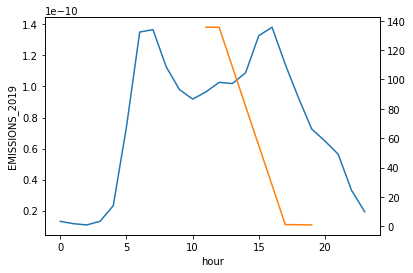

In [178]:
hourly.mean(['latitude', 'longitude']).plot()
ax = plt.gca()
ax2 = ax.twinx()
hourwise.weighted.plot(ax=ax2, c='C1')

In [141]:
hourwise#.JF.plot(c='C1')

,PC,LE,SU,SP,JF,FF,CN,speed,weighted
time,,,,,,,,,
16,23240.325644,2.377232,49.550278,48.375247,0.761699,51.384235,0.805068,NaN,1.339210
17,23240.325644,2.377232,50.510084,49.102577,0.659244,51.384235,0.799344,NaN,1.089091
18,23240.325644,2.377232,51.123597,49.733147,0.565959,51.384235,0.779277,NaN,0.980133
11,23240.325644,2.377232,NaN,NaN,51.384235,NaN,NaN,46.931131,135.531452
